In [1]:
using Plots
using ReinforcementLearning
using Flux
using Flux.Losses
using IntervalSets
using StableRNGs
# using Flux.Optimise
# using Flux: crossentropy, ADAM
# using LinearAlgebra
# using DifferentialEquations
# import Base.rand
# import Random: Sampler, SamplerSimple, Repetition, eltype
# import Random: seed!
# using CUDA
using FurutaPendulums
using BSON

In [2]:
mutable struct FurutaEnv <: AbstractEnv
    state
    reward::AbstractFloat
    action_space
    action::AbstractFloat
    state_space
    done
    furuta
    t
    dt
    tmax
end

function FurutaEnv(;
        max_u=5.,
        max_dθ=100.,
        max_dϕ=100.,
        dt = 0.01,
        tmax = 10.
        )
    high = [Inf,max_dθ,Inf,max_dϕ]
    low = [-Inf,-max_dθ,-Inf,-max_dϕ]
    furuta = SimulatedFurutaPendulum()
    
    FurutaEnv(
        furuta.x,
        0.,
        ClosedInterval.(-max_u,max_u),
        0.,
        Space(ClosedInterval{Float64}.(low, high)),
        false,
        furuta,
        0.,
        dt,
        tmax
        )
end

RLBase.action_space(env::FurutaEnv) = env.action_space
RLBase.state_space(env::FurutaEnv) = env.state_space
function RLBase.reward(env::FurutaEnv)
#     x = env.furuta.x
#     ϕ, ϕdot, θ, θdot = [x[1],x[2],rem2pi(x[3],RoundNearest),x[4]]
    env.reward = -abs(0.0018522 - 0.0018522 * (cos(env.state[3])) - 0.00000387 * env.state[4]^2)
end
RLBase.is_terminated(env::FurutaEnv) = env.done
RLBase.state(env::FurutaEnv) = env.state

function (env::FurutaEnv)(a::AbstractFloat)
    @assert a in env.action_space
    env.action = a
    dt = env.dt
    control(env.furuta,a)
    periodic_wait(env.furuta,env.t,dt)
    env.state[:] = [env.furuta.x[1],env.furuta.x[2],rem2pi(env.furuta.x[3], RoundNearest),env.furuta.x[4]]
    env.t += dt
    env.done = env.t >= env.tmax
    nothing
end

function RLBase.reset!(env::FurutaEnv)
    env.action = 0.
    env.reward = 0.
    env.t = 0.
    env.furuta = SimulatedFurutaPendulum()
    env.state = env.furuta.x
#     env.state[3] = 0.
    env.done = false
end

In [54]:
env = FurutaEnv(max_u=5,
        max_dθ=100,
        max_dϕ=100)
env(2.)

In [ ]:
run(
           RandomPolicy(),
           FurutaEnv(),
           StopAfterEpisode(10),
           TotalRewardPerEpisode()
       )

[ Info: Saved animation to d:\group-2\src\anim_pendulum.gif


Plots.AnimatedGif("d:\\group-2\\src\\anim_pendulum.gif")
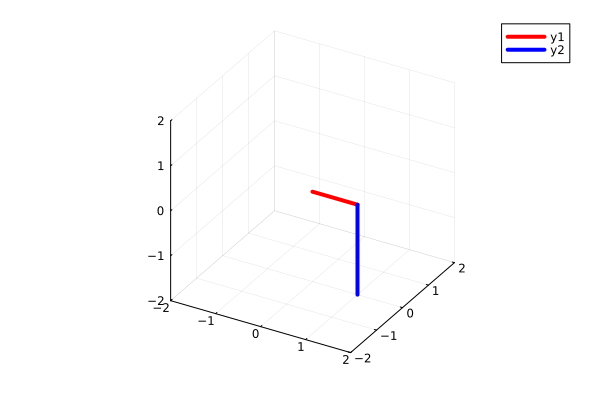

In [5]:
include("sim/env.jl")

env = FurutaEnv()
# env.state[3] = 0.
dt = 0.02
tmax = 10.
tspan = 0.:dt:tmax
xs = zeros(length(tspan),4)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    u = ex.policy(env)
    env(u)
end
plot(tspan,xs)
animate_pendulum(xs[:,1],xs[:,3],tmax)

# Play Pendulum with TD3


Progress: 100%|█████████████████████████████████████████| Time: 0:03:39


             ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
             ┌────────────────────────────────────────┐ 
           0 │⠀⣀⠀⠀⠀⠀⢠⣤⣄⣀⣤⠶⠒⠲⠒⠒⠒⠚⠚⠶⡶⠿⠛⠋⠙⠉⠉⢹⠉⠉⠉⠉⠉⠉⢹⠹⡏⠋⠉⠉│ 
             │⠀⣿⠀⣴⣾⣤⡇⠀⠉⠁⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀│ 
             │⢤⠻⠚⠃⢸⡟⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⢸⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score     │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -20 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
             └─────────────────

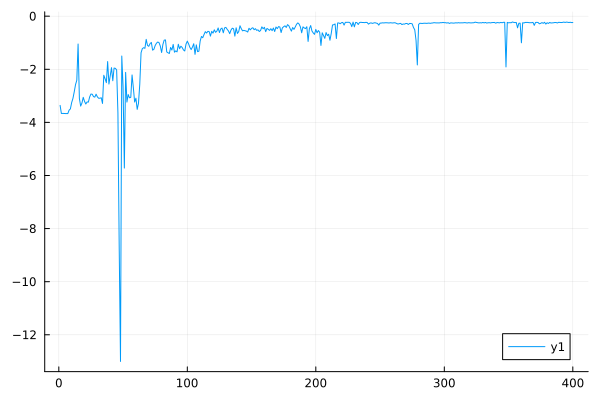

In [4]:

function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    env = FurutaEnv()
#     inner_env = FurutaEnv()
    A = action_space(env)
#     low = A.left
#     high = A.right
    ns = length(state(env))

#     env = ActionTransformedEnv(
#         env;
#         action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
#     )
    init = glorot_uniform(rng)

    create_actor() = Chain(
        Dense(ns, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1, tanh; init = init),
    ) |> cpu

    create_critic_model() = Chain(
        Dense(ns + 1, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1; init = init),
    ) |> cpu

    create_critic() = TD3Critic(create_critic_model(), create_critic_model())

    agent = Agent(
        policy = TD3Policy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            γ = 0.99f0,
            ρ = 0.99f0,
            batch_size = 64,
            start_steps = 1000,
            start_policy = RandomPolicy(-1.0..1.0; rng = rng),
            update_after = 1000,
            update_freq = 1,
            policy_freq = 2,
            target_act_limit = 1.0,
            target_act_noise = 0.1,
            act_limit = 1.0,
            act_noise = 0.1,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 200_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
        ),
    )

    #stop_condition = StopAfterStep(10000, is_show_progress=!haskey(ENV, "CI"))
    stop_condition = StopAfterEpisode(400; cur = 0, is_show_progress = true)
    hook = TotalRewardPerEpisode() 
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

using Plots
ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

# Play Pendulum with TD3


Progress: 100%|█████████████████████████████████████████| Time: 0:02:45


            ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
            ┌────────────────────────────────────────┐ 
          0 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀│ 
            │⠀⢰⣧⡔⣼⠺⢷⢶⣷⠒⢹⡏⠎⠛⠉⠋⠋⠛⠋⠛⠛⠗⠞⣷⠛⠙⠙⠋⠓⠓⠒⠛⠛⠙⠙⠋⠉⠛⠛⠁│ 
            │⡇⣿⠹⡇⡿⠀⠘⠈⠇⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⣷⠇⠀⡇⡇⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⡿⠀⠀⡇⠁⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠇⠀⠀⡇⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score    │⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -3 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            └───────────────────────────────────

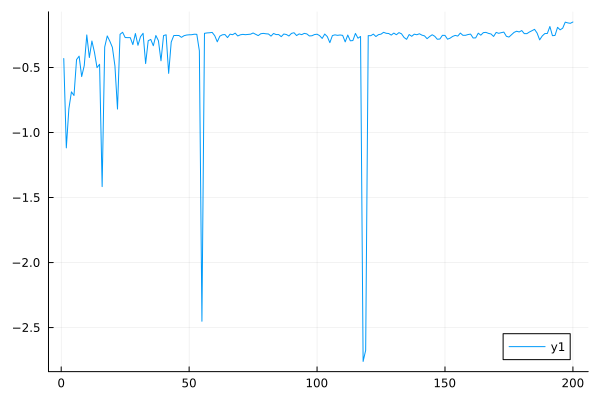

In [22]:

function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    env = FurutaEnv()
#     inner_env = FurutaEnv()
    A = action_space(env)
#     low = A.left
#     high = A.right
    ns = length(state(env))

#     env = ActionTransformedEnv(
#         env;
#         action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
#     )

    agent = ex.policy

    #stop_condition = StopAfterStep(10000, is_show_progress=!haskey(ENV, "CI"))
    stop_condition = StopAfterEpisode(200; cur = 0, is_show_progress = true)
    hook = TotalRewardPerEpisode() 
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

using Plots
ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

In [24]:
model = ex.policy
BSON.@save "model.bson" model

In [ ]:
actor = ex.policy.behavior_actor
BSON.@save "actor.bson" actor

In [ ]:
using Random
T = Float64
p_env = PendulumEnv(;
    max_speed = T(8),
    max_torque = T(2),
    g = T(10),
    m = T(1),
    l = T(1),
    dt = T(0.05),
    max_steps = 200,
    continuous = true,
    n_actions = 3,
    rng = Random.GLOBAL_RNG,
)